# **DATA PROCESSING**

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [2]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_UG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_UG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/Colab Notebooks/CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'Code', 'Models', 'CW_Dataset', 'Personal_Dataset', 'test_functions.ipynb']


### Load packages

In the next cell you should load all the packages required to test your functions.

In [3]:
import torch
import random
import numpy as np
import joblib
from PIL import Image, ImageEnhance
from torchvision import transforms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from skimage.feature import hog
from skimage import color
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

### Loading the Dataset, Augmenting and Enhancing images

In [4]:
# Load the dataset
def load_dataset(root_dir, subfolder='train'):
    img_dir = os.path.join(root_dir, subfolder, 'images')
    labels_dir = os.path.join(root_dir, subfolder, 'labels')
    img_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith(('.jpg', '.jpeg', '.png'))]
    images, labels = [], []
    for img_name in img_names:
        img_path = os.path.join(img_dir, img_name)
        label_path = os.path.join(labels_dir, os.path.splitext(img_name)[0] + '.txt')
        image = Image.open(img_path).convert('RGB')
        label = int(open(label_path, 'r').read().strip())
        images.append(image)
        labels.append(label)
    return images, labels

# Image enhancement and augmentation
TARGET_SIZE = (224, 224)
def process_images(images):
    def enhance_image(image):
        image = image.resize(TARGET_SIZE, Image.Resampling.LANCZOS)
        image = ImageEnhance.Contrast(image).enhance(1.8)
        image = ImageEnhance.Brightness(image).enhance(1.2)
        return image
    augmentation_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2)
    ])
    images = [enhance_image(image) for image in images]
    return [augmentation_transform(image) for image in images]

# Extract HOG features
def extract_hog_features(images):
    hog_features = []
    for image in images:
        gray_image = color.rgb2gray(np.array(image))
        features = hog(gray_image, orientations=8, pixels_per_cell=(16, 16),
                       cells_per_block=(1, 1), visualize=False, multichannel=False)
        hog_features.append(features)
    return np.array(hog_features)

# Normalize features
def normalize_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

# Main sequence
root_dir = '/content/drive/MyDrive/Colab Notebooks/CW_Folder_UG/CW_Dataset'
images, labels = load_dataset(root_dir, 'train')

# Split data first
X_train_raw, X_test_raw, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, stratify=labels)

# Process training and test images separately
X_train = process_images(X_train_raw)
X_test = process_images(X_test_raw)

# Extract HOG features from processed images
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

# Normalize HOG features based on training set
scaler = StandardScaler()
X_train_hog_norm = scaler.fit_transform(X_train_hog)
X_test_hog_norm = scaler.transform(X_test_hog)

# Address class imbalance on the training set only
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_hog_norm, y_train)

print(f"Original dataset shape: {Counter(labels)}")
print(f"Resampled training set shape: {Counter(y_train_res)}")



<ipython-input-4-9c40b0af0e91>:37: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features = hog(gray_image, orientations=8, pixels_per_cell=(16, 16),


Original dataset shape: Counter({1: 1940, 0: 376, 2: 78})
Resampled training set shape: Counter({1: 1552, 0: 1552, 2: 1552})


###Visualisation of the Dataset

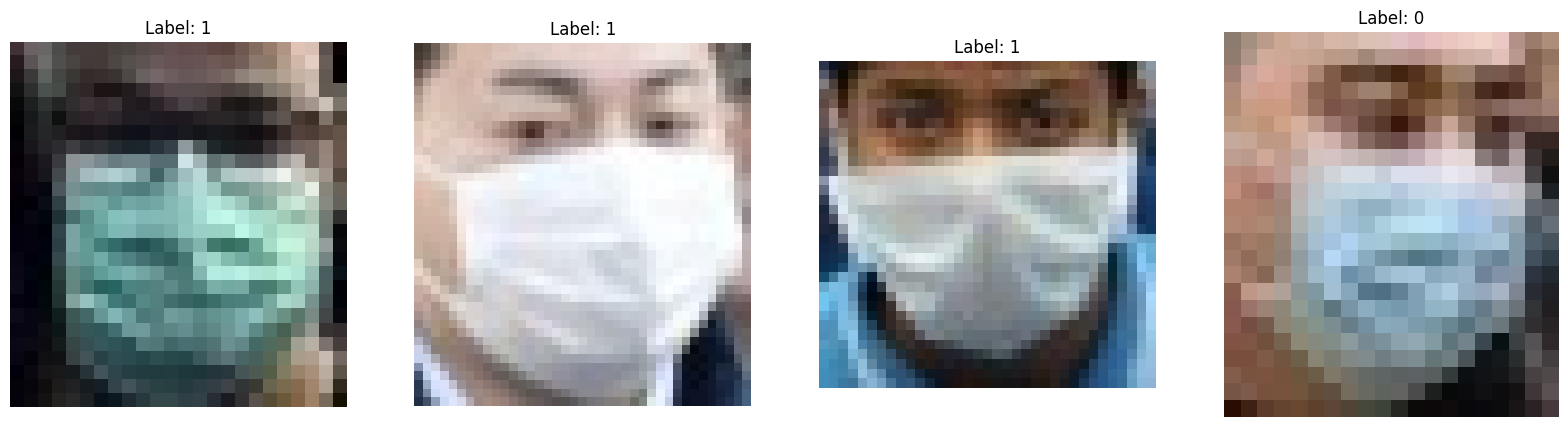

In [5]:
def visualize_random_images(images, labels, num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))
    selected_indices = random.sample(range(len(X_train_raw)), num_images)

    for i, idx in enumerate(selected_indices):
        image = images[idx]
        label = labels[idx]
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

# Visualise the images
visualize_random_images(X_train_raw, labels)


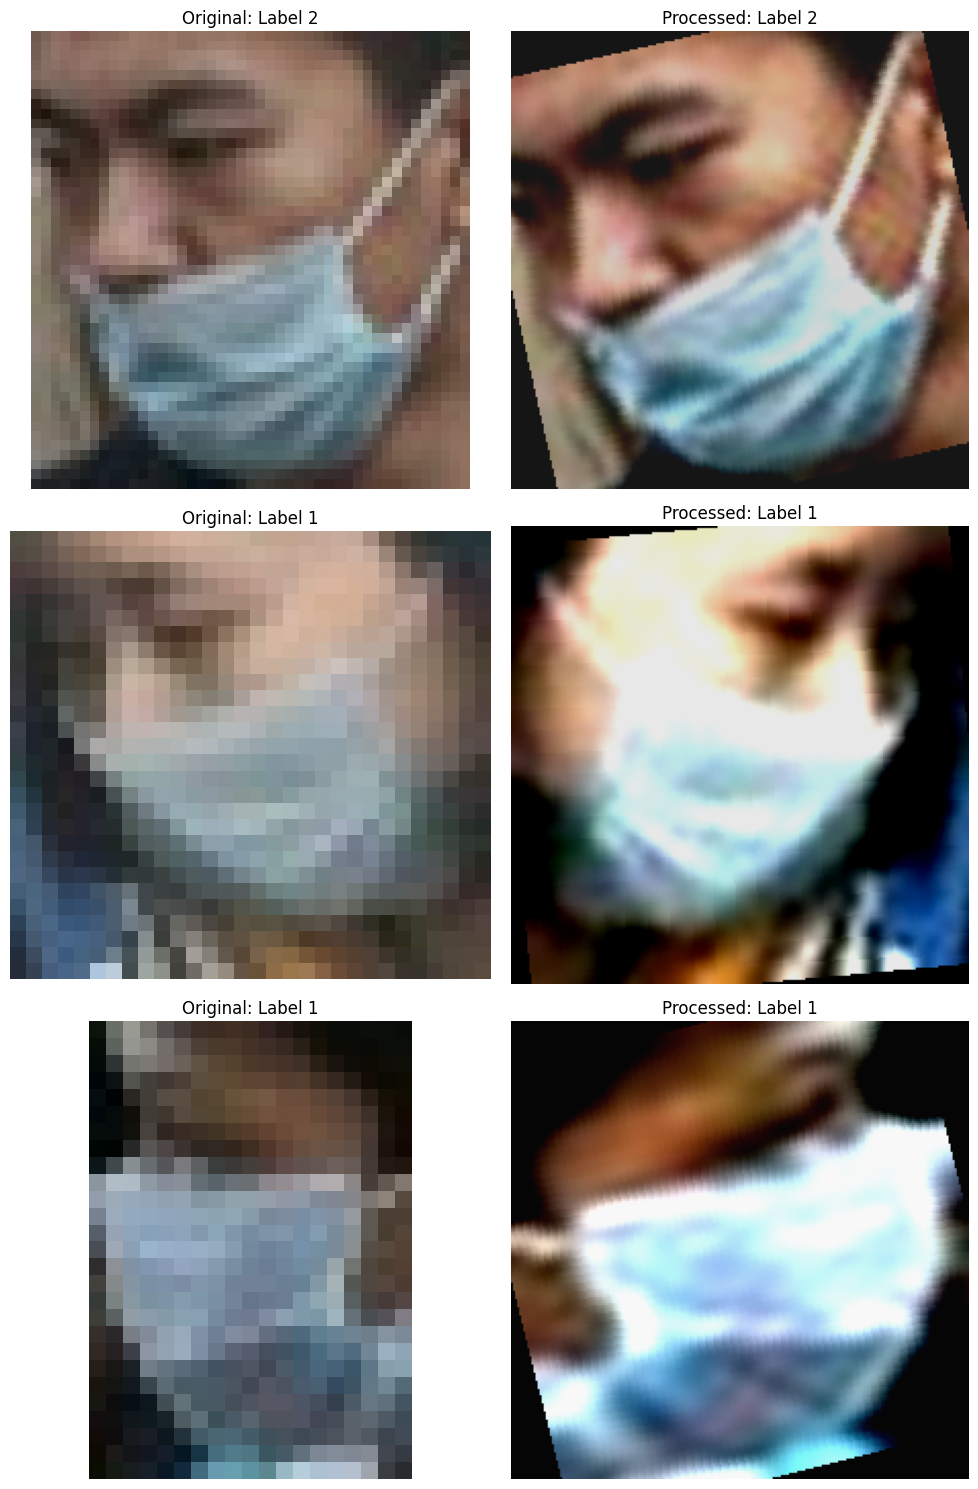

In [7]:
# Visualising the enhancemnt on the images
def visualize_improvements(original_images, processed_images, labels, num_images=3):
    fig, axs = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    idx_list = random.sample(range(len(original_images)), num_images)

    for row, idx in enumerate(idx_list):
        original_image = np.array(original_images[idx])
        processed_image = processed_images[idx]

        label = labels[idx]

        # Plot the original and processed images
        axs[row, 0].imshow(original_image)
        axs[row, 0].set_title(f"Original: Label {label}")
        axs[row, 1].imshow(processed_image)
        axs[row, 1].set_title(f"Processed: Label {label}")
        for ax in axs[row]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()
X_train_res, y_train_res
visualize_improvements(X_train_raw, X_train, y_train, num_images=3)

### MLP Model

In [8]:
# Define the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(50, 100), max_iter=100, alpha=1e-4,
                               solver='sgd', verbose=True, random_state=1,
                               learning_rate_init=.1)

# Train the MLPClassifier using HOG features from the training set
mlp.fit(X_train_res, y_train_res)


Iteration 1, loss = 0.38225987
Iteration 2, loss = 0.03412585
Iteration 3, loss = 0.00675481
Iteration 4, loss = 0.00133968
Iteration 5, loss = 0.00045082
Iteration 6, loss = 0.00027024
Iteration 7, loss = 0.00021579
Iteration 8, loss = 0.00018696
Iteration 9, loss = 0.00016855
Iteration 10, loss = 0.00015507
Iteration 11, loss = 0.00014470
Iteration 12, loss = 0.00013639
Iteration 13, loss = 0.00012962
Iteration 14, loss = 0.00012402
Iteration 15, loss = 0.00011903
Iteration 16, loss = 0.00011500
Iteration 17, loss = 0.00011098
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(hidden_layer_sizes=(50, 100), learning_rate_init=0.1,
              max_iter=100, random_state=1, solver='sgd', verbose=True)

In [9]:
# Predict the labels of the test set
y_pred= mlp.predict(X_test_hog_norm)

# Print the classification report
print(f"Classification report for classifier {mlp}:\n{classification_report(y_test, y_pred)}")


Classification report for classifier MLPClassifier(hidden_layer_sizes=(50, 100), learning_rate_init=0.1,
              max_iter=100, random_state=1, solver='sgd', verbose=True):
              precision    recall  f1-score   support

           0       0.63      0.51      0.56        75
           1       0.88      0.94      0.91       388
           2       0.17      0.06      0.09        16

    accuracy                           0.84       479
   macro avg       0.56      0.50      0.52       479
weighted avg       0.82      0.84      0.83       479



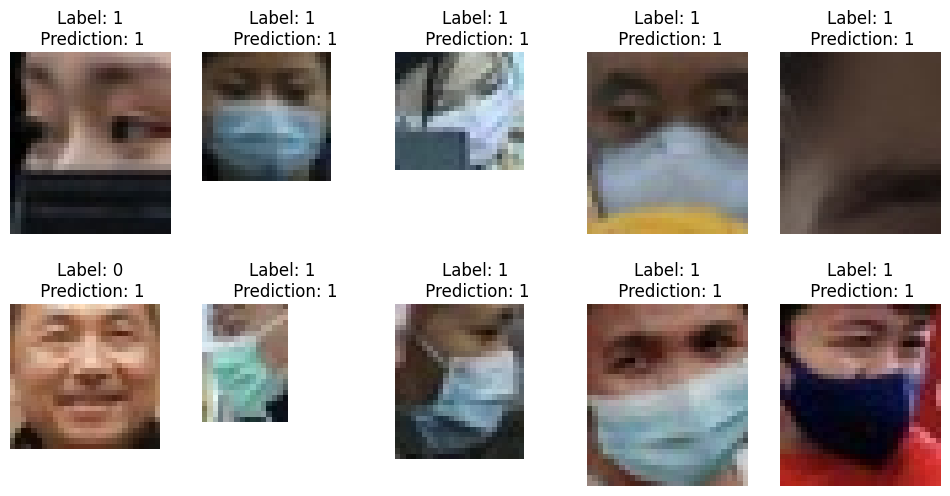

In [10]:
X_test, y_test, y_pred = shuffle(X_test_raw, y_test, y_pred)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i], cmap='gray')
    ax[i].set_title(f'Label: {y_test[i]}\n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout
plt.show()

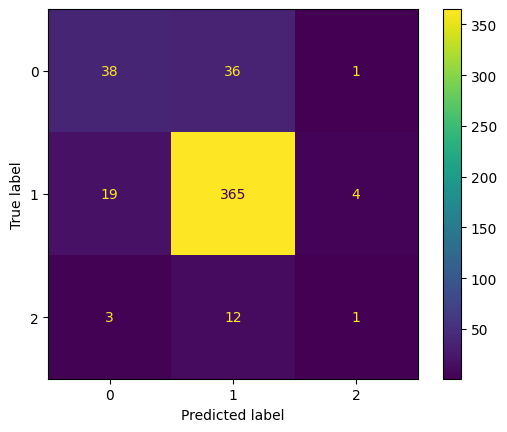

In [11]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Saving the Model

In [ ]:
# Directory where the model will be saved
model_dir = '/content/drive/MyDrive/Colab Notebooks/CW_Folder_UG/Models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Path to save the model file
model_path = os.path.join(model_dir, 'HOG_MLP_model.pkl')

# Save the MLP model
joblib.dump(mlp, model_path)

print(f"Model saved successfully at {model_path}")
